## Exploratory data analysis of Dranse discharge data

Summary: The data is stationary even without differencing, but ACF and PACF plots show that an hourly first order difference and a periodic 24h first order difference is needed for SARIMA fitting.

## SARIMAX model fitting

### 1.) Loading the river flow (discharge) data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [84]:
from river_forecast.training_data_access import get_combined_flow

In [85]:
flow_df = get_combined_flow()

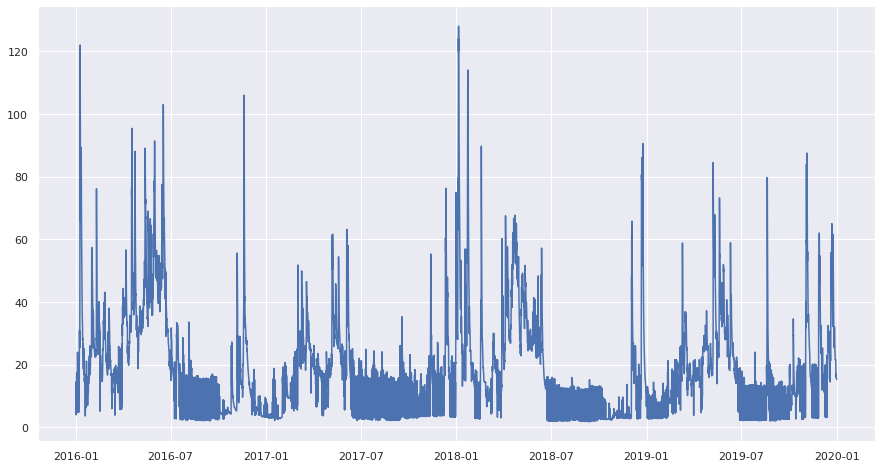

In [86]:
plt.plot(flow_df.index, flow_df)

In [87]:
flow_df.to_csv('data/hourly_flows_2016-19.csv')

### Exploratory Analysis

In [88]:
subset_df = flow_df.loc[:]
subset_df['year'] = subset_df.index.year
subset_df['offset_datetime'] = subset_df.index + pd.DateOffset(year=2019)

/home/mnolte/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:692: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


In [8]:
sns.set(style="whitegrid")

Text(0, 0.5, 'Discharge (m^3/s)')

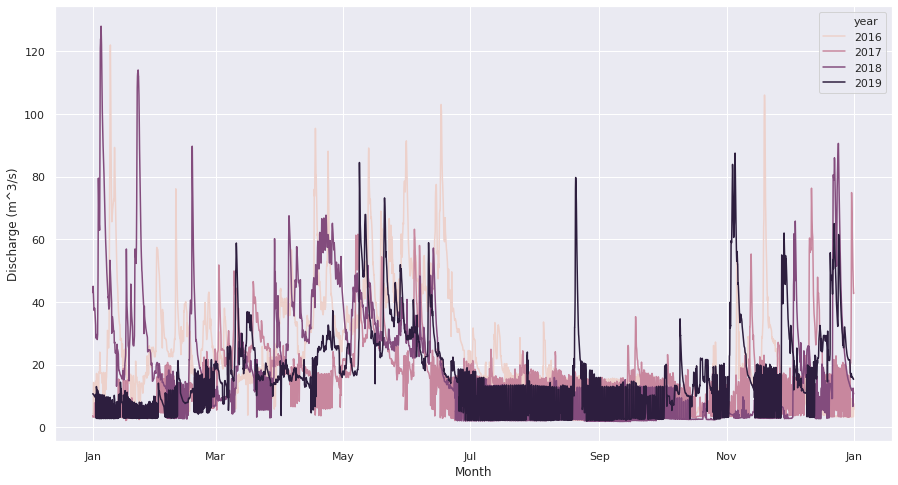

In [9]:
sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='offset_datetime', y='discharge', hue='year', data=subset_df, markers='')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')
ax.get_xaxis().set_major_formatter(myFmt)
ax.set_xlabel('Month')
ax.set_ylabel('Discharge (m^3/s)')

### train-test split

In [10]:
import statsmodels.api as sm

In [11]:
train = flow_df.loc[flow_df.index < pd.to_datetime('2019-01-01 00:00:00')]
test = flow_df.loc[(flow_df.index >= pd.to_datetime('2019-01-01 00:00:00')) & (flow_df.index < pd.to_datetime('2019-07-01 00:00:00'))]

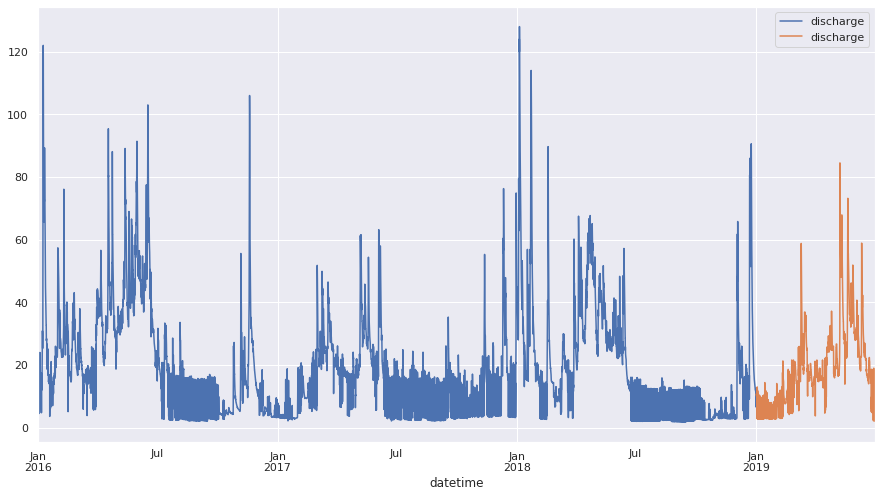

In [12]:
fig, ax = plt.subplots()
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.legend()
plt.show()

### Time series stationarity analysis

In [13]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [14]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        -> Adapted from from kaggle (https://gist.github.com/DmitrySerg/14c1af2c1744bb9931d1eae6d9713b21)
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        t_statistic, p_value = sm.tsa.stattools.adfuller(y)[:2]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#### Augmenteded Dicky-Fuller to check for stationarity


In [15]:
flow = flow_df['discharge']
flow_diff_1 = (flow - flow.shift(1)).dropna()
flow_diff_1_24 = (flow_diff_1 - flow_diff_1.shift(24)).dropna()
flow_diff_24 = (flow - flow.shift(24)).dropna()

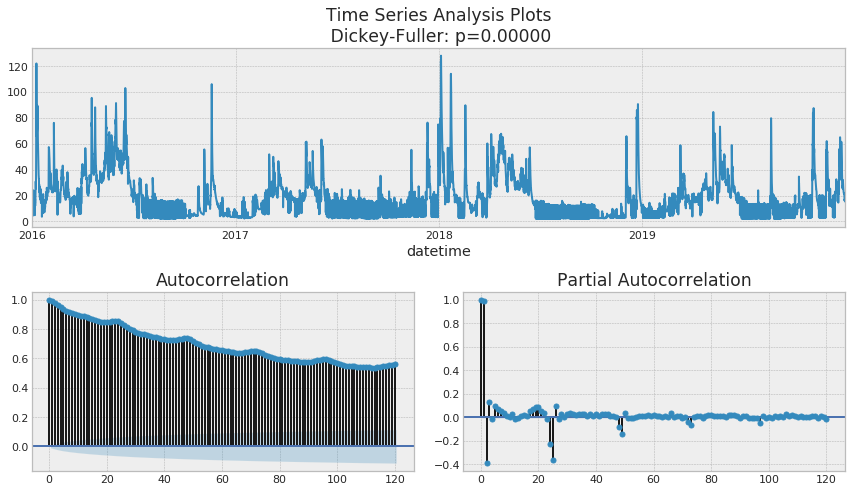

In [16]:
 tsplot(flow, lags=24*5, figsize=(12, 7))

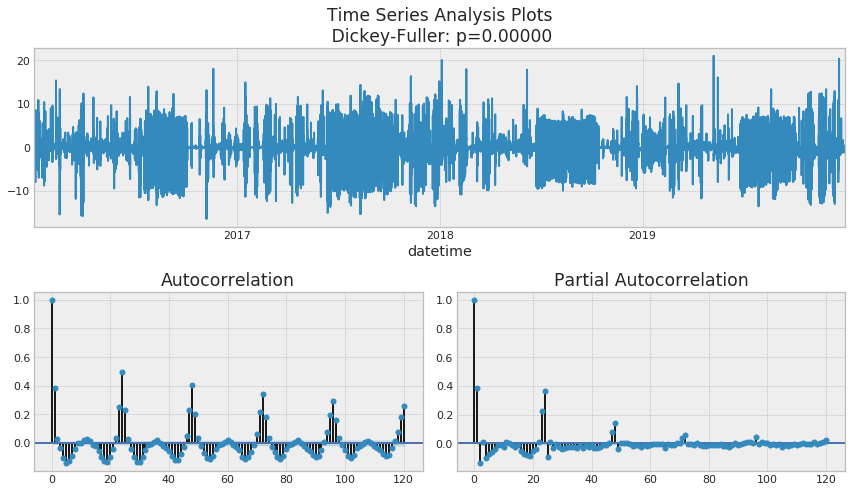

In [17]:
 tsplot(flow_diff_1, lags=24*5, figsize=(12, 7))

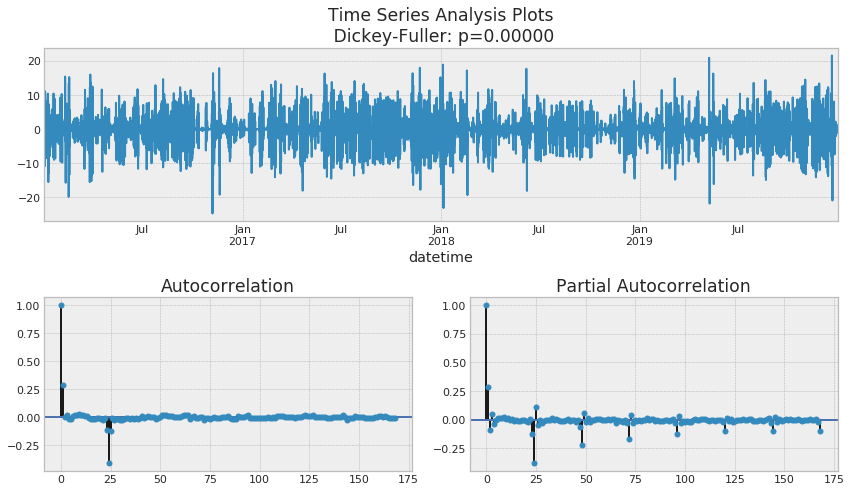

In [18]:
 tsplot(flow_diff_1_24, lags=24*7, figsize=(12, 7))

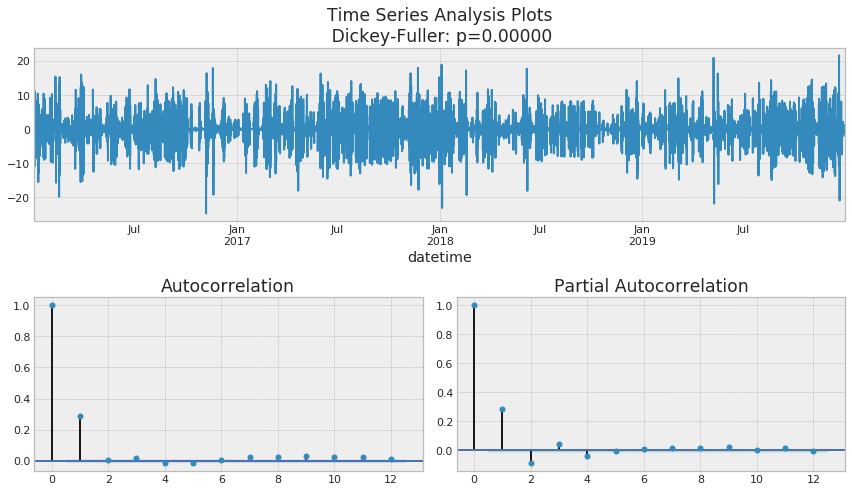

In [19]:
 tsplot(flow_diff_1_24, lags=12, figsize=(12, 7))

#### Fitting SARIMAX

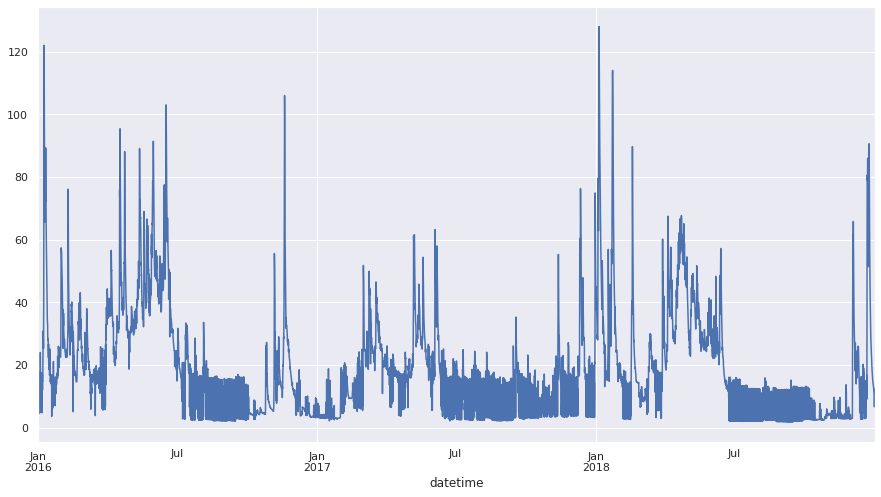

In [20]:
train['discharge'].plot()

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
### Crashed again upon completion, make sure the time series is ok -> computation moved to Colab

# Create a SARIMAX model
model = SARIMAX(train['discharge'], order=(4,1,1), seasonal_order=(0,1,1,24))
# p - try 0, 1, 2, 3, 4; q is cleary one. Q is clearly 1, P is tapering off: 0.

In [26]:
# Fit the model
results = model.fit()

In [59]:
import pickle
pickle.dump(results.params, open('models/sarimax_211_011-24_model-parameters.pkl', 'wb'))
### # load model
###  loaded = ARIMAResults.load('model.pkl')

In [57]:
results = pickle.load(open('models/sarimax_411_011-24_model.pkl', 'rb'))

In [58]:
# Print the results summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          discharge   No. Observations:                26304
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -51111.394
Date:                            Wed, 08 Jul 2020   AIC                         102236.789
Time:                                    16:52:10   BIC                         102294.024
Sample:                                01-01-2016   HQIC                        102255.270
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5842      0.059      9.911      0.000       0.469       0.700
ar.L2         -0.2164      0.020   

In [29]:
results

#### Plotting the forecast

In [30]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-48)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower discharge']
upper_limits = confidence_intervals.loc[:, 'upper discharge']


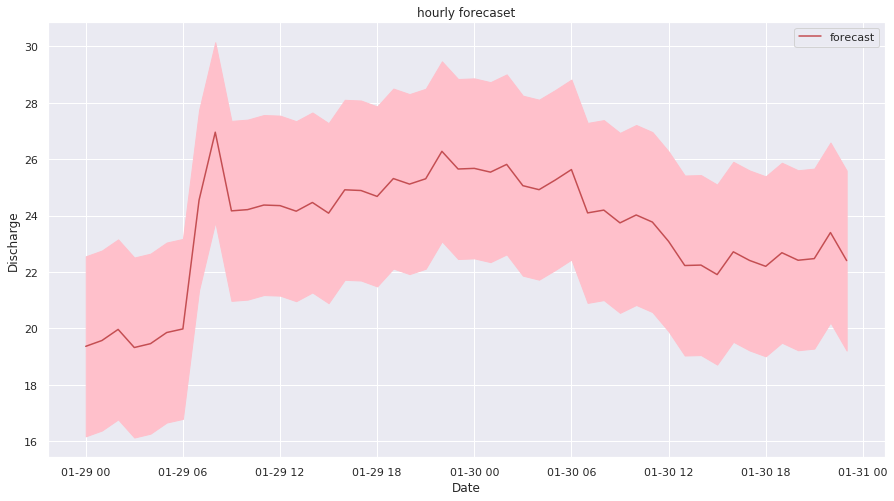

In [83]:
# plot the dranse data

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('hourly forecaset')
plt.legend()
plt.show()

In [34]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-6, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int(alpha=0.32) # 95 percent confidence interval

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower discharge']
upper_limits = confidence_intervals.loc[:,'upper discharge']


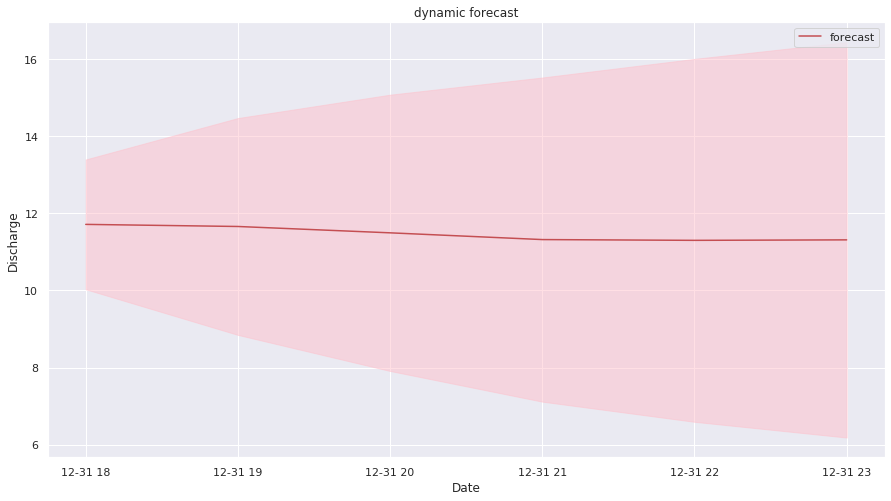

In [36]:
# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink', alpha=0.5)

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('dynamic forecast')
plt.legend()

#### Finding the best model manually

In [37]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0, 5):
    print(p)
    # create and fit ARMA(p,q) model
    model = SARIMAX(train['discharge'], order=(p,1,1), seasonal_order=(0,1,1,24))
    # p - try 0, 1, 2, 3, 4; q is cleary one. Q is clearly 1, P is tapering off: 0.
    results = model.fit()
        
    # Append order and results tuple
    order_aic_bic.append((p,results.aic, results.bic))

0
1
2
3
4


In [38]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p            AIC            BIC
4  4  102236.788642  102294.024320
3  3  102311.143591  102360.202744
1  1  102320.155001  102352.861103
2  2  102322.067849  102362.950476
0  0  102324.493738  102349.023315
   p            AIC            BIC
4  4  102236.788642  102294.024320
0  0  102324.493738  102349.023315
1  1  102320.155001  102352.861103
3  3  102311.143591  102360.202744
2  2  102322.067849  102362.950476


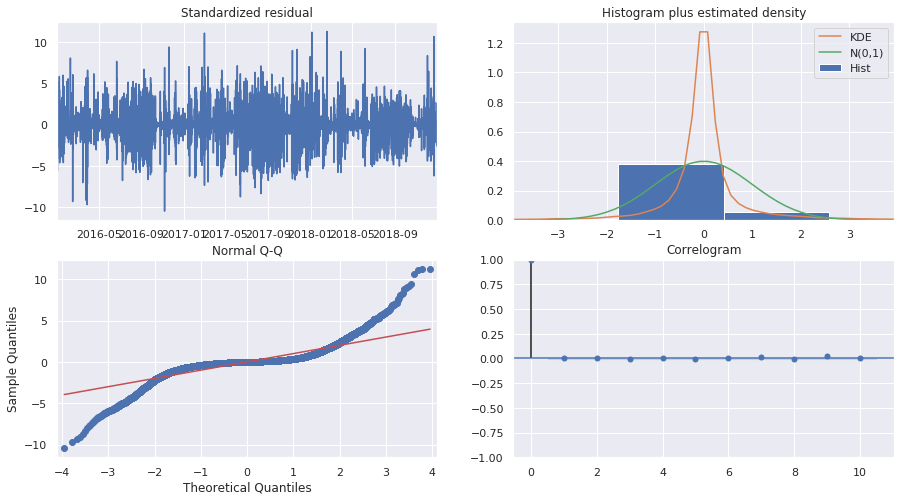

                                     SARIMAX Results                                      
Dep. Variable:                          discharge   No. Observations:                26304
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -51111.394
Date:                            Tue, 07 Jul 2020   AIC                         102236.789
Time:                                    16:37:34   BIC                         102294.024
Sample:                                01-01-2016   HQIC                        102255.270
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5842      0.059      9.911      0.000       0.469       0.700
ar.L2         -0.2164      0.020   

In [39]:
# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

# Print summary
print(results.summary())

### Forecasting

In [34]:
results.forecast(steps=6)

2019-01-01 00:00:00    10.592045
2019-01-01 01:00:00    10.236778
2019-01-01 02:00:00    10.169845
2019-01-01 03:00:00    10.047900
2019-01-01 04:00:00     9.876444
2019-01-01 05:00:00     9.684441
Freq: H, dtype: float64

/home/mnolte/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/mnolte/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [51]:
resB.forecast(steps=6)

/home/mnolte/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


69    11.701410
70     2.215435
71     3.633658
72     3.441690
73     3.536395
74     3.540859
dtype: float64

In [60]:
import river_forecast.api_data_access
import importlib, sys

In [47]:
importlib.reload(river_forecast.api_data_access)

<module 'river_forecast.api_data_access' from '/home/mnolte/repos/river_forecast/river_forecast/api_data_access.py'>

In [61]:
rivermap_data = river_forecast.api_data_access.RivermapDataRetriever()

In [62]:
recent_flow_df = rivermap_data.get_latest_river_flow(n_days=3, station='Dranse')

In [63]:
recent_flow_df

,discharge
datetime,
2020-07-05 16:00:00,5.35
2020-07-05 16:30:00,5.18
2020-07-05 17:00:00,5.18
2020-07-05 17:30:00,5.18
2020-07-05 18:00:00,5.18
...,...
2020-07-08 13:30:00,12.40
2020-07-08 14:00:00,12.40
2020-07-08 14:30:00,12.40


In [51]:
modelB = SARIMAX(recent_flow_df.iloc[:2].asfreq('h'), order=(4,1,1), seasonal_order=(0,1,1,24))
resB = modelB.smooth(results.params)

NameError: name 'SARIMAX' is not defined

In [99]:
resB.forecast(steps=6)

2020-07-07 16:00:00    4.435813
2020-07-07 17:00:00    4.133641
2020-07-07 18:00:00    4.167330
2020-07-07 19:00:00    4.097179
2020-07-07 20:00:00    4.156958
2020-07-07 21:00:00    4.106104
Freq: H, dtype: float64

In [1]:
from river_forecast.api_data_access import RivermapDataRetriever
data = RivermapDataRetriever().get_standard_dranse_data()


In [2]:
data

,discharge
datetime,
2020-07-06 17:30:00,5.69
2020-07-06 18:30:00,5.69
2020-07-06 19:30:00,5.86
2020-07-06 20:30:00,5.86
2020-07-06 21:30:00,5.69
...,...
2020-07-09 12:30:00,12.40
2020-07-09 13:30:00,12.00
2020-07-09 14:30:00,4.66


In [8]:
import importlib
import river_forecast.forecast
importlib.reload(river_forecast.forecast)

<module 'river_forecast.forecast' from '/home/mnolte/repos/river_forecast/river_forecast/forecast.py'>

In [9]:
sf = river_forecast.forecast.SARIMAXForecast()

(<Figure size 720x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f222c03a750>)

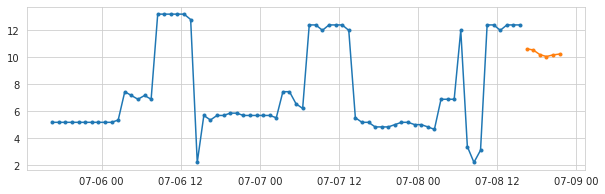

In [10]:
sf.generate_prediction_plot(data)

In [22]:
sf.dynamic_forecast(data)

2020-07-08 16:30:00    10.628188
2020-07-08 17:30:00    10.543754
2020-07-08 18:30:00    10.200522
2020-07-08 19:30:00    10.058293
2020-07-08 20:30:00    10.176873
2020-07-08 21:30:00    10.240719
Freq: H, dtype: float64

In [14]:
import pandas as pd

In [20]:
data['discharge'].iloc[:1]

datetime
2020-07-05 16:30:00    5.18
Freq: H, Name: discharge, dtype: float64

In [32]:
data.iloc[-1:].index.strftime("%c")[0]

'Wed Jul  8 15:30:00 2020'

In [34]:
data.iloc[-1]

discharge    12.4
Name: 2020-07-08 15:30:00, dtype: float64

#### Naive Forecast

In [21]:
import pandas as pd

In [13]:
data

,discharge
datetime,
2020-07-06 17:30:00,5.69
2020-07-06 18:30:00,5.69
2020-07-06 19:30:00,5.86
2020-07-06 20:30:00,5.86
2020-07-06 21:30:00,5.69
...,...
2020-07-09 12:30:00,12.40
2020-07-09 13:30:00,12.00
2020-07-09 14:30:00,4.66


In [28]:
data.iloc[-1:].index.to_pydatetime()

array([datetime.datetime(2020, 7, 9, 16, 30)], dtype=object)

In [36]:
last_timestamp = data.iloc[-1:].index.to_pydatetime()[0]
forecast_index = pd.date_range(last_timestamp + pd.Timedelta(hours=1),
                               last_timestamp + pd.Timedelta(hours=5), freq="h")

In [40]:
pd.Series([data.iloc[-1].values[0] for _ in range(5)], index=forecast_index)

2020-07-09 17:30:00    4.2
2020-07-09 18:30:00    4.2
2020-07-09 19:30:00    4.2
2020-07-09 20:30:00    4.2
2020-07-09 21:30:00    4.2
Freq: H, dtype: float64